# Escrapeamos los datos de la pagina **https://super.facua.org/** para guardarlos en un .cvs

## Importamos las librerias que vamos a usar

In [1]:
from bs4 import BeautifulSoup

import requests

import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from time import sleep
import sys
sys.path.append('../')

from src import support_scrapping_datos as sup_scrap

import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Escrapeamos los productos para cada uno de estos supermercados

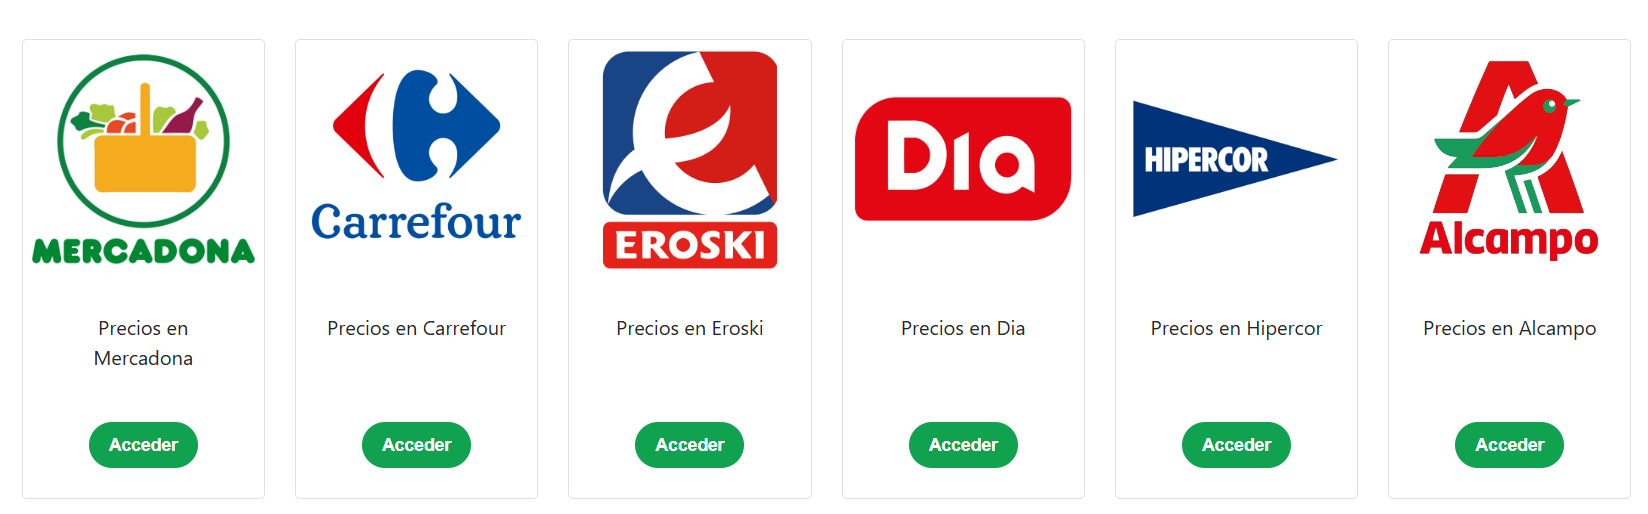

### los diferentes supermercados los 'hardcodeo' ahora y luego lo hago dinamico por si cambian en algun futuro. Pero de momento para ir mas rapido, lo quedo a mano.

In [59]:
supermercados = ['mercadona', 'carrefour', 'eroski', 'dia', 'hipercor', 'alcampo']

### Creamos un diccionario para que nos devuelva dinamicamente las urls para el supermercado que queramos y los productos categorizados

In [60]:
urls_base = {
    "aceite_girasol":{
        'categoria': 'Aceite Girasol',
        'subcategoria': 'Aceite Girasol',
        'url': lambda x: f'https://super.facua.org/{x}/aceite-de-girasol/',
    },
    "aceite_oliva_suave_intenso":{
        'categoria': 'Aceite Oliva',
        'subcategoria': 'Suave e Intenso',
        'url': lambda x: f'https://super.facua.org/{x}/aceite-de-oliva/suave-e-intenso/',
    },
    "aceite_oliva_virgen": {
        'categoria': 'Aceite Oliva',
        'subcategoria': 'Virgen',
        'url': lambda x: f'https://super.facua.org/{x}/aceite-de-oliva/virgen/',
    },
    "aceite_oliva_virgen_extra": {
        'categoria': 'Aceite Oliva',
        'subcategoria': 'Virgen Extra',
        'url': lambda x: f'https://super.facua.org/{x}/aceite-de-oliva/virgen-extra/',
    },
    "leche_enriquecida": {
        'categoria': 'Leche',
        'subcategoria': 'Enriquecida',
        'url': lambda x: f'https://super.facua.org/{x}/leche/enriquecida/',
    },
    "entera_semi_desnatada": {
        'categoria': 'Leche',
        'subcategoria': 'Entera Semi Desnatada',
        'url': lambda x: f'https://super.facua.org/{x}/leche/entera-semi-desnatada/',
    },
    "leche_sin_lactosa": {
        'categoria': 'Leche',
        'subcategoria': 'Sin Lactosa',
        'url': lambda x: f'https://super.facua.org/{x}/leche/sin-lactosa/',
    }
}

### Extraemos los datos, los categorizamos y los convertimos a DataFrame

In [61]:
data = []
for supermercado in tqdm(supermercados):
    for key, value in urls_base.items():

        url = value['url'](supermercado)#esto nos devuelve la url para el supermercado que queremos

        respuesta = requests.get(url)

        if respuesta.status_code == 200:
            contenido_html = respuesta.text

        sopa = BeautifulSoup(contenido_html, 'html.parser')

        #tarjetas de los productos con la informacion que necesitamos
        tarjetas = sopa.find_all('div', {'class', 'card h-100'})
    
        for tarjeta in tarjetas:
            supermercado_perteneciente = supermercado
            categoria = value['categoria']
            subcategoria = value['subcategoria']

            nombre = tarjeta.find('p', {'class', 'fw-bolder'}).text.strip()
            cantidad, unidad = sup_scrap.extraer_cantidad_unidad(nombre)

            nombre_partido = nombre.split()
            unidad_ = nombre_partido.pop()
            cantidad_ = nombre_partido.pop()
            nombre_junto = " ".join(nombre_partido)

            
            url_historico = tarjeta.find('div', {'class', 'card-footer p-4 pt-0 border-top-0 bg-transparent'}).find('a').get('href')
            
            data.append({
                'supermercado': supermercado_perteneciente,
                'categoria': categoria,
                'subcategoria': subcategoria,
                'nombre': nombre_junto,
                'cantidad': cantidad,
                'unidad': unidad,
                'url_historico': url_historico
            })

        sleep(1)

df = pd.DataFrame(data)

100%|██████████| 6/6 [00:48<00:00,  8.13s/it]


### Vemos cuantos productos tenemos

In [62]:
df.shape

(1543, 7)

In [63]:
df.sample(3)

,supermercado,categoria,subcategoria,nombre,cantidad,unidad,url_historico
1071,hipercor,Leche,Entera Semi Desnatada,Leyma Natura Leche Desnatada Brik,1,l,https://super.facua.org/hipercor/leche/leyma-n...
695,hipercor,Aceite Oliva,Suave e Intenso,Carbonell Aceite De Oliva Extra Suave Botella,1,l,https://super.facua.org/hipercor/aceite-de-oli...
1085,hipercor,Leche,Entera Semi Desnatada,Madriz Leche Desnatada Brik,1,l,https://super.facua.org/hipercor/leche/madriz-...


### Comprobamos si tenemos duplicados

In [64]:
df.duplicated().sum()

18

### Eliminamos los duplicados

In [65]:
df.drop_duplicates(inplace=True)

## Ahora comprobamos los nulos

In [66]:
df.isna().sum()

supermercado      0
categoria         0
subcategoria      0
nombre            0
cantidad         64
unidad           64
url_historico     0
dtype: int64

In [67]:
df_nulos = df[(df['unidad'].isna()) & (df['cantidad'].isna())]

### vemos en las categorias que tenemos los nulos

In [68]:
df_nulos['categoria'].unique()

array(['Aceite Oliva', 'Leche'], dtype=object)

### Voy a eliminar los nulos del aceite de oliva debido a que vemos todos menos 1 son productos los cuales no son aceite

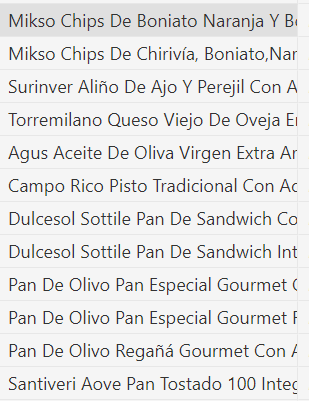

In [69]:
df.drop(df[(df['categoria'] == 'Aceite Oliva') & (df['cantidad'].isna())].index, inplace=True)

In [70]:
df.shape

(1507, 7)

## Anadimos indices al dataframe

In [88]:
df['id'] = df.index

## Corregimos el tipo de dato a las columnas necesarias

In [4]:
df_productos = pd.read_csv('../datos/df_productos_2024-10-26.csv', index_col=0)

## En este caso, solo haria falta convertir cantidad a tipo float y los id a tipo int

In [5]:
df_productos.sample()

,supermercado,categoria,subcategoria,nombre,cantidad,unidad,url_historico,id
44,carrefour,Aceite Girasol,Aceite Girasol,Aceite De Girasol Fontasol,1,l,https://super.facua.org/carrefour/aceite-de-gi...,44


In [7]:
df_productos['cantidad'] = df_productos['cantidad'].str.replace(',','.').astype(float)

In [10]:
df_productos['id'] = df_productos['id'].astype(int)

In [12]:
df_productos.head(3)

,supermercado,categoria,subcategoria,nombre,cantidad,unidad,url_historico,id
0,mercadona,Aceite Girasol,Aceite Girasol,"Aceite De Girasol Refinado 0,2º Hacendado",1.0,l,https://super.facua.org/mercadona/aceite-de-gi...,0
1,mercadona,Aceite Girasol,Aceite Girasol,"Aceite De Girasol Refinado 0,2º Hacendado",5.0,l,https://super.facua.org/mercadona/aceite-de-gi...,1
2,mercadona,Aceite Oliva,Suave e Intenso,Aceite De Oliva Intenso Hacendado,3.0,l,https://super.facua.org/mercadona/aceite-de-ol...,2


## Guardamos los datos de los productos

In [15]:
fecha = datetime.datetime.today().date()

#df_productos.to_csv(f'../datos/df_productos_{fecha}.csv')
df_productos.to_csv(f'../datos/tablas/tabla_productos_{fecha}.csv')

# Obtenemos los historicos de cada producto mediante su url

In [2]:
df_productos = pd.read_csv('../datos/df_productos_2024-10-26.csv', index_col=0)

In [167]:
df_productos.sample()

,supermercado,categoria,subcategoria,nombre,cantidad,unidad,url_historico,id
740,hipercor,Aceite Oliva,Virgen Extra,Aceites De Ardales Aceite De Oliva Virgen Extr...,500,ml,https://super.facua.org/hipercor/aceite-de-oli...,740


In [169]:
df_historico_sucio = pd.DataFrame()

for i, fila in tqdm(df_productos.iterrows()):

    url = fila['url_historico']
    respuesta = requests.get(url)
    
    sopa = ""
    if respuesta.status_code == 200:
        sopa = BeautifulSoup(respuesta.text, 'html.parser')

    tabla = sopa.find('table', {'class': 'table table-striped table-responsive text-center'})

    filas = tabla.find_all('tr')
    encabezados_html = filas.pop(0)

    encabezados = [h.text for h in encabezados_html.findAll('th')]

    df_historico = pd.DataFrame([d.findAll('td') for d in filas], columns=encabezados).map(lambda x: x.text)

    #limpiamos un poco la columna variacion y sacamos 'cantidad_aumento' y 'porcentaje' de esta
    df_historico['Variación'] = df_historico['Variación'].str.replace('=', '+0,00 (0,00%)')
    df_historico['Variación'] = df_historico['Variación'].str.replace('(','').str.replace('%)','')
    df_historico[['cantidad_aumento', 'porcentaje']] = df_historico['Variación'].str.split(' ', expand=True)

    #ahora la eliminamos
    df_historico.drop(columns=['Variación'], inplace=True)

    #le concatenamos el id del producto del cual estamos obteniendo el historico
    df_historico['id_producto'] = fila['id']
    
    df_historico_sucio = pd.concat([df_historico_sucio, df_historico], ignore_index=True)
    
    #dejamos un segundo antes de hacer la siguiente peticion
    sleep(1)

#le asigmanos id a cada registro del dataframe
df_historico_sucio['id'] = df_historico_sucio.index
    

1507it [30:30,  1.21s/it]


In [171]:
df_historico_sucio.sample(5)

,Día,Precio (€),cantidad_aumento,porcentaje,id_producto,id
10894,03/09/2024,"7,55","+0,00","0,00",112,10894
116417,25/08/2024,"2,35","+0,00","0,00",1399,116417
32072,13/09/2024,"1,69","+0,00","0,00",425,32072
38152,01/09/2024,"1,17","+0,00","0,00",489,38152
73376,01/09/2024,"15,65","+0,00","0,00",888,73376


In [172]:
fecha = datetime.datetime.today().date()
#df_historico_sucio.to_csv(f'../datos/df_historico{fecha}.csv')

In [173]:
df_historico_sucio.shape

(128393, 6)

In [192]:
df_historico = pd.read_csv('../datos/df_historico2024-10-26.csv', index_col=0)

In [193]:
df_historico.head()

,Día,Precio (€),cantidad_aumento,porcentaje,id_producto,id
0,12/07/2024,"1,45","+0,00","0,00",0,0
1,13/07/2024,"1,45","+0,00","0,00",0,1
2,14/07/2024,"1,45","+0,00","0,00",0,2
3,15/07/2024,"1,45","+0,00","0,00",0,3
4,16/07/2024,"1,45","+0,00","0,00",0,4


## Ponemos el campo 'Día' de tipo fecha y con el formato 'Anio,Mes,Dia'

In [194]:
df_historico['Día'] = pd.to_datetime(df_historico['Día'], format='%d/%m/%Y')

### Ahora ponemos el porcentaje y el precio en decimal

In [195]:
df_historico['porcentaje'] = df_historico['porcentaje'].str.replace(',','.').astype(float)
df_historico['Precio (€)'] = df_historico['Precio (€)'].str.replace(',','.').astype(float)

### Hacemos lo mismo con 'cantidad_aumento' pero viendo si es negativo o positivo

In [196]:
def normalizar_cantidad_aumento(aumento):
    aumento = aumento.replace(',','.')
    if aumento.startswith('-'):
        return float(aumento[1:]) * -1
    else:
        return float(aumento[1:])

In [197]:
df_historico['cantidad_aumento'] = df_historico['cantidad_aumento'].apply(normalizar_cantidad_aumento)

### Por ultimo, ponemos los ids con valor numerico tambien

In [199]:
df_historico[['id_producto', 'id']] = df_historico[['id_producto', 'id']].astype(int)

In [200]:
df_historico.head()

,Día,Precio (€),cantidad_aumento,porcentaje,id_producto,id
0,2024-07-12,1.45,0.0,0.0,0,0
1,2024-07-13,1.45,0.0,0.0,0,1
2,2024-07-14,1.45,0.0,0.0,0,2
3,2024-07-15,1.45,0.0,0.0,0,3
4,2024-07-16,1.45,0.0,0.0,0,4


## Guardamos el dataframe ahora que lo tenemos como queremos para despues, exportarlo como tabla a nuestra base de datos

In [203]:
# fecha = datetime.datetime.today().date()
# df_historico.to_csv(f'../datos/tablas/tabla_historico{fecha}.csv')

<h2 style="color: red;">RECORDAR APLICAR TIPO DE DATO A LOS DFS</h2>